# cadCAD Tutorials: The Robot and the Marbles Part 5- Networks

To expand upon our previous examples, we will introduce the concept of using a graph network object that is updated during each state update. The ability to essential embed a graph 'database' into a state is a game changer for scalability, allowing increased complexity with multiple agents or components is represented, easily updated. Below, building upon our previous examples, we will represent the Robots and Marbles example with n boxes, and a variable number of marbles. 

## Behavior and Mechanisms:
* A network of robotic arms is capable of taking a marble from their one of their boxes and dropping it into the other one. 
* Each robotic arm in the network only controls two boxes and they act by moving a marble from one box to the other.
* Each robotic arm is programmed to take one marble at a time from the box containing the most significant number of marbles and drop it in the other box. It repeats that process until the boxes contain an equal number of marbles.
* For our analysis of this system, suppose we are only interested in monitoring the number of marbles in only their two boxes.

In [1]:
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD.configuration import Configuration
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# define global variables
scale=200 # for plotting
T = 25 #iterations in our simulation
boxes=5 #number of boxes in our network
m= 2 #for barabasi graph type number of edges is (n-2)*m

We create a [Barabási–Albert](https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model) graph and then fill the 5 boxes with between 1 and 10 balls.

In [2]:
# create graph object
network = nx.barabasi_albert_graph(boxes, m)

# initial matrix for boxes and balls
balls = np.zeros(boxes,)

# add balls to box nodes
for node in network.nodes:
    rv = np.random.randint(1,10)
    network.nodes[node]['initial_balls'] = rv
    balls[node] = rv

Now we will plot the network of boxes and with their labels showing how many balls are in each box.

/home/aclarkdata/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


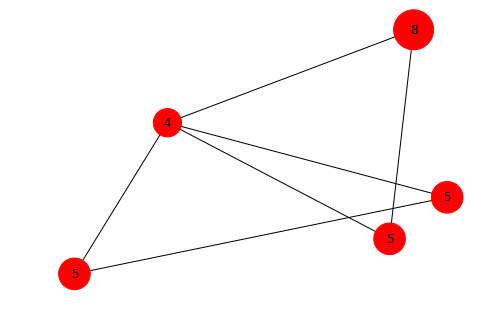

In [3]:
# plot of boxes and balls
nx.draw_kamada_kawai(network, node_size=balls*scale,labels=nx.get_node_attributes(network,'initial_balls'))

In [4]:
# we initialize the cadCAD state of balls
initial_conditions = {'balls':balls}

In [5]:
#Behavior: node by edge dimensional operator
#input the states of the boxes output the deltas along the edges

# We specify the robotic networks logic in a Policy/Behavior Function
# unlike previous examples our policy controls a vector valued action, defined over the edges of our network
def robotic_network(params, step, sL, s):
    
    delta_balls = {}
    for e in network.edges:
        src = e[0]
        dst = e[1]
        #transfer one ball across the edge in the direction of more balls to less
        delta_balls[e] = np.sign(s['balls'][src]-s['balls'][dst])

    return({'delta': delta_balls})

In [6]:
#mechanism: edge by node dimensional operator
#input the deltas along the edges and update the boxes

# We make the state update functions less "intelligent",
# ie. they simply add the number of marbles specified in _input 
# (which, per the policy function definition, may be negative)

def update_balls(params, step, sL, s, _input):
    
    delta_balls = _input['delta']
    new_balls = s['balls']
    for e in network.edges:
        move_ball = delta_balls[e]
        src = e[0]
        dst = e[1]
        if (new_balls[src] >= move_ball) and (new_balls[dst] >= -move_ball):
            new_balls[src] = new_balls[src]-move_ball
            new_balls[dst] = new_balls[dst]+move_ball
            
    
    key = 'balls'
    value = new_balls
    
    return (key, value)

In [7]:
# wire up the mechanisms and states
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'robotic_network': robotic_network
        },
        'variables': { # The following state variables will be updated simultaneously
            'balls': update_balls,
            
        }
    }
]

In [8]:
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
simulation_parameters = {
    'T': range(T),
    'N': 1,
    'M': {}
}

In [9]:
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

In [10]:
# Run the simulations
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results
df = pd.DataFrame(raw_result)

single_proc: [<cadCAD.configuration.Configuration object at 0x7f4401badb00>]


In [11]:
# view the dataframe
df

,balls,run,substep,timestep
0,"[5.0, 8.0, 4.0, 5.0, 5.0]",1,0,0
1,"[4.0, 6.0, 8.0, 4.0, 5.0]",1,1,1
2,"[5.0, 6.0, 4.0, 5.0, 7.0]",1,1,2
3,"[4.0, 6.0, 8.0, 4.0, 5.0]",1,1,3
4,"[5.0, 6.0, 4.0, 5.0, 7.0]",1,1,4
5,"[4.0, 6.0, 8.0, 4.0, 5.0]",1,1,5
6,"[5.0, 6.0, 4.0, 5.0, 7.0]",1,1,6
7,"[4.0, 6.0, 8.0, 4.0, 5.0]",1,1,7
8,"[5.0, 6.0, 4.0, 5.0, 7.0]",1,1,8
9,"[4.0, 6.0, 8.0, 4.0, 5.0]",1,1,9


Next we will plot the number of balls in each box over the simulation time period. We can see an oscillation occurs never reaching an equilibrium due to the uneven nature of the boxes and balls.

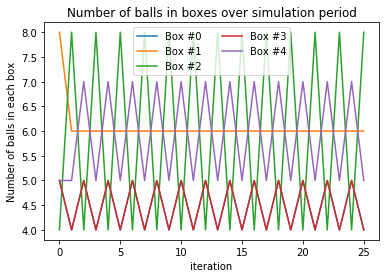

In [12]:
balls_list = [b for b in df.balls]
plt.plot(df.timestep.values, balls_list)
plt.xlabel('iteration')
plt.ylabel('Number of balls in each box')
plt.title('Number of balls in boxes over simulation period')
plt.legend(['Box #'+str(node) for node in range(boxes)], ncol = 2)

Finally, we will get the ending network balls state and plot.

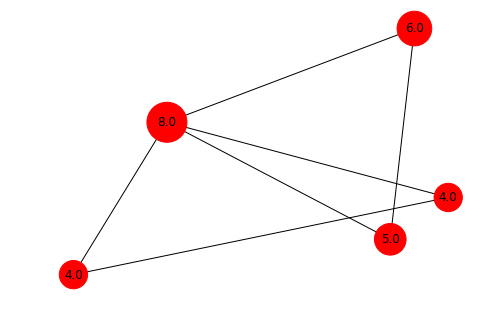

In [13]:
end_state_balls = np.array([b for b in balls_list[-1]])

for node in network.nodes:
    network.nodes[node]['final_balls'] = end_state_balls[node]
    
# number of ending balls
nx.draw_kamada_kawai(network, node_size=end_state_balls*scale, labels=nx.get_node_attributes(network,'final_balls'))

In summary, we created a graph network of boxes and robotic arms to transfer balls between the boxes, striving for an unachievable equilibrium state. The ability to embed a graph, virtually a graph database, into a cadCAD state allows for tremendous scalability and flexibility as a modeling tool.  